In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
import censusdata

# Comparitive Analysis on Census Block Group Diversity Index of Boston and NYC in 2020

### Step 1: Import Supporting Shape Files

    1. Boston Block Group 2020 shapefile
    2. NYC Block Group 2020 shapefile

In [2]:
#import boston block groups 2020

blockgroup20_BOS = gpd.read_file('../Data/Census2020_BlockGroups/Census2020_BlockGroups.shp')
#exclude Harbor Islands
blockgroup20_BOS = blockgroup20_BOS[blockgroup20_BOS['GEOID20'] != '250259801011']
blockgroup20_BOS = blockgroup20_BOS.to_crs('epsg:4326')
blockgroup20_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_STAr,Shape_STLe,geometry
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,413598.0,+42.3833695,-071.0707743,1.807118e+07,29256.866068,"POLYGON ((-71.08097 42.38232, -71.08095 42.382..."
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,0.0,+42.3882285,-071.0046816,2.374654e+06,9142.174252,"POLYGON ((-71.01084 42.38613, -71.00891 42.386..."
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,270.0,+42.3913407,-071.0020343,2.446949e+06,11579.546171,"POLYGON ((-71.00629 42.39098, -71.00628 42.391..."
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,158777.0,+42.3886205,-070.9934424,8.026752e+06,16626.718823,"POLYGON ((-71.00113 42.38710, -71.00100 42.387..."
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,0.0,+42.3459611,-071.1020344,1.570220e+06,5510.560013,"POLYGON ((-71.10507 42.34670, -71.10457 42.346..."


In [3]:
#import NY state block groups and filter to only NYC counties (New York, Kings, Queens, Bronx, Richmond)
nyc_counties = ['047', '005','081','085','061']

blockgroup20_NY = gpd.read_file('../Data/cb_2021_36_bg_500k/cb_2021_36_bg_500k.shp')
blockgroup20_NY = blockgroup20_NY[(blockgroup20_NY['COUNTYFP'].isin(nyc_counties)) & (blockgroup20_NY['ALAND'] != 0)]
blockgroup20_NY.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
0,36,081,093401,2,1500000US360810934012,360810934012,2,Block Group 2,BG,132716,0,"POLYGON ((-73.84400 40.57951, -73.84305 40.577..."
2,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,0,"POLYGON ((-73.79188 40.85522, -73.78743 40.849..."
5,36,061,015001,1,1500000US360610150011,360610150011,1,Block Group 1,BG,25990,0,"POLYGON ((-73.95881 40.78086, -73.95720 40.780..."
7,36,047,033300,1,1500000US360470333001,360470333001,1,Block Group 1,BG,46523,0,"POLYGON ((-73.94244 40.66673, -73.93968 40.666..."
8,36,061,008900,3,1500000US360610089003,360610089003,3,Block Group 3,BG,40799,0,"POLYGON ((-74.00553 40.74582, -74.00269 40.744..."


### Step 2: Find Relevant Race Data Sets and Geography Codes for Bos & NYC

        - Historical Boston Hispanic or Latino Race Counts per BG
        - NYC Hispanic or Latino Race Counts per BG


In [4]:
#get census column names we want to pull using the census api
census_columns = []

for i in range(1,13):
    if i == 2 or i == 10 or i == 11:
        pass
    elif i <10:
        census_columns.append('B03002_00{}E'.format(i))
    else:
        census_columns.append('B03002_0{}E'.format(i))

print(census_columns)

#column categorical values
column_vals = ['Total', 'White, not hispanic', 'Black or African American, not hispanic',\
               'American Indian and Alaska Native, not hispanic', 'Asain, not hispanic',\
               'Native Hawaiian and Other Pacific Islander, not hispanic', 'Some other race alone, not hispanic',\
               'Two or More Races, not hispanic', 'Hispanic or Latino']

#create dictionary to rename table columns later on
col_dict = {census_columns[i]: column_vals[i] for i in range(len(column_vals))}
print(col_dict)

['B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E', 'B03002_009E', 'B03002_012E']
{'B03002_001E': 'Total', 'B03002_003E': 'White, not hispanic', 'B03002_004E': 'Black or African American, not hispanic', 'B03002_005E': 'American Indian and Alaska Native, not hispanic', 'B03002_006E': 'Asain, not hispanic', 'B03002_007E': 'Native Hawaiian and Other Pacific Islander, not hispanic', 'B03002_008E': 'Some other race alone, not hispanic', 'B03002_009E': 'Two or More Races, not hispanic', 'B03002_012E': 'Hispanic or Latino'}


In [5]:
#get state and county ids for both new york and boston
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2020)
print(states['New York'], states['Massachusetts'])

boscounties = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2020)
print(boscounties['Suffolk County, Massachusetts'])


nyccounties = censusdata.geographies(censusdata.censusgeo([('state', '36'), ('county', '*')]), 'acs5', 2020)
print(nyccounties["Kings County, New York"], nyccounties["Bronx County, New York"],\
      nyccounties["Queens County, New York"], nyccounties["Richmond County, New York"], nyccounties["New York County, New York"])

Summary level: 040, state:36 Summary level: 040, state:25
Summary level: 050, state:25> county:025
Summary level: 050, state:36> county:047 Summary level: 050, state:36> county:005 Summary level: 050, state:36> county:081 Summary level: 050, state:36> county:085 Summary level: 050, state:36> county:061


### State and County Metadata from the information provided above:

### New York State ID = 36
        New York County = 061
        Kings County = 047
        Bronx County = 005
        Queens County = 081
        Richmond County = 085
### Massachusetts State ID = 25
        Suffolk County ID = 025

In [6]:
#define function to retrieve census/ACS data given the variables defined above
def get_acs5_data(yr,stateid,countyid,column_ls,column_dict):
    """
    Parameters
    ----------
    yr: int
        The census year of interest
    stateid: str
        State id  of interest in the form of a string
    countyid: str
        County id of interest in the form of a string
    column_ls: list
        The list of ACS column values you are looking to extract
    column_dict: dict
        Dictionary assigning categorical values to associated ACS column
        
        key: ACS column (e.g. B3002_001E)
        value: Categorical value (e.g. 'Total')
        
    Returns
    -------
    df: dataframe
        Dataframe containing population counts of interest at the available
        geographical/spatial resolution (e.g. census blocks, tracts, block groups)
    """
    
    df = censusdata.download('acs5', yr,
               censusdata.censusgeo([('state', stateid),
                                     ('county', countyid),
                                     ('block group', '*')]),
                                      column_ls)
    df.reset_index(inplace=True)
    df['index'] = df['index'].astype('str')
    
    Block_Group = []
    tract = []
    for index, row in df.iterrows():
        Block_Group.append(row['index'][:13])
        tract.append(row['index'][-21:-15])

    df['Block Group'] = Block_Group
    df['Tract'] = tract
    
    df = df.rename(columns = col_dict)
    df = df.rename(columns = {'index':'Geographical Information'})
    
    return df

# Join ACS ethnicity tbl to shapefiles

## Boston

In [7]:
bos_ethnicity = get_acs5_data(2020,'25','025',census_columns,col_dict) 
bos_ethnicity.head()

,Geographical Information,Total,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,"Block Group 3, Census Tract 1304.02, Suffolk C...",732,491,0,0,46,0,0,12,183,Block Group 3,130402
1,"Block Group 2, Census Tract 1304.04, Suffolk C...",940,752,24,0,99,0,0,9,56,Block Group 2,130404
2,"Block Group 3, Census Tract 1304.06, Suffolk C...",390,214,95,0,0,0,0,0,81,Block Group 3,130406
3,"Block Group 1, Census Tract 1403, Suffolk Coun...",1172,54,422,0,0,0,0,0,696,Block Group 1,140300
4,"Block Group 4, Census Tract 1403, Suffolk Coun...",1006,204,766,0,0,0,0,0,36,Block Group 4,140300


In [8]:
acs5_blockgroup_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACTCE20','NAMELSAD20'], right_on = ['Tract','Block Group'])
acs5_blockgroup_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,1086,165,0,102,0,0,25,101,Block Group 1,040600
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,...,956,162,0,82,0,0,0,1191,Block Group 1,051101
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,...,326,26,0,18,0,0,0,649,Block Group 4,051101
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,...,0,0,0,0,0,0,0,0,Block Group 1,981600
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,...,465,34,0,201,0,0,15,56,Block Group 3,010204


<AxesSubplot:>

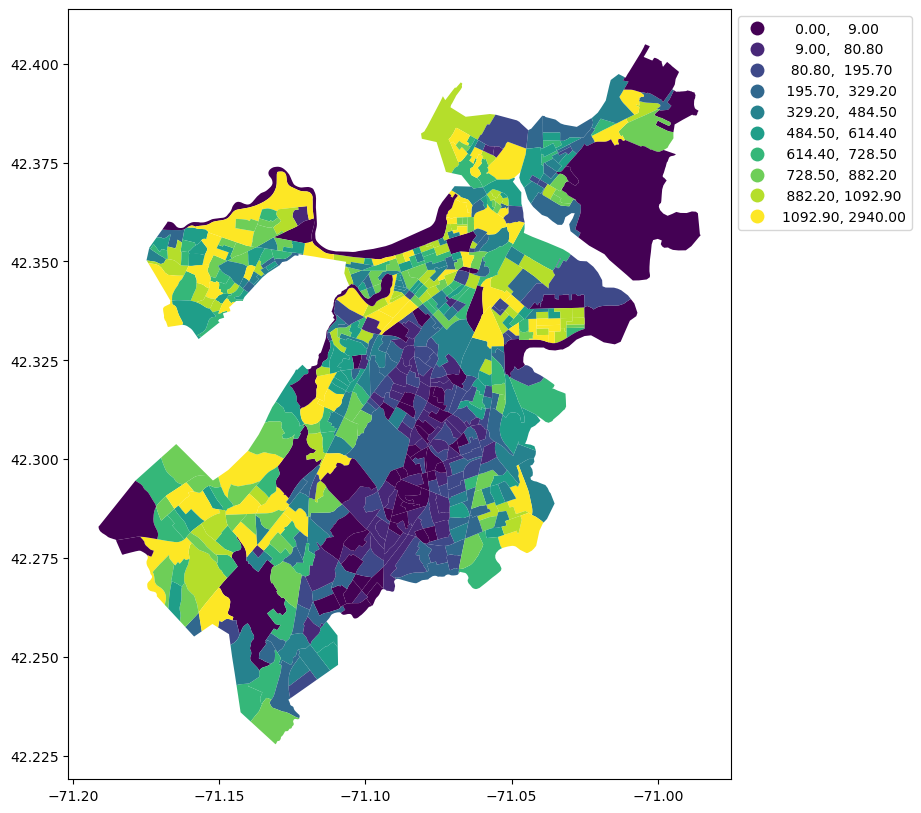

In [9]:
acs5_blockgroup_BOS.plot(column = 'White, not hispanic', k=10, scheme='Quantiles',legend=True, figsize = (10,10)
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

## NYC

<AxesSubplot:>

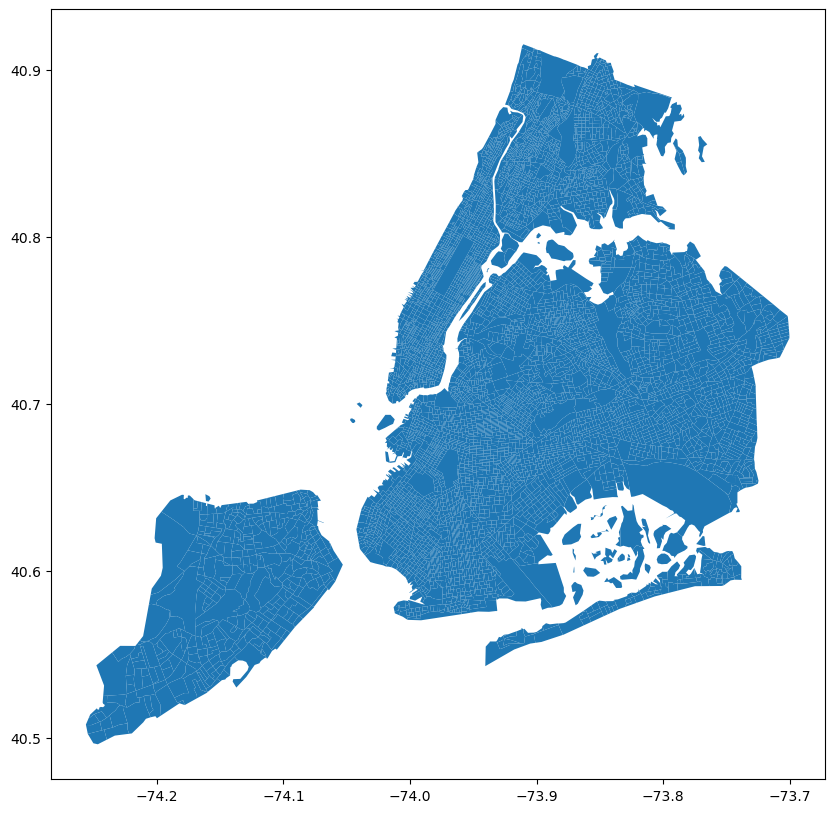

In [10]:
blockgroup20_NY.plot(figsize = (10,10))

In [11]:
nyc_ethnicity = get_acs5_data(2020,'36',nyc_counties[0],census_columns,col_dict)

for county in nyc_counties[1:]:
    nyc_ethnicity = nyc_ethnicity.append(get_acs5_data(2020,'36',county,census_columns,col_dict))   
    print(len(nyc_ethnicity))

acs5_blockgroup_NY = blockgroup20_NY.merge(nyc_ethnicity, how = 'left', left_on = ['TRACTCE','NAMELSAD'], right_on = ['Tract','Block Group'])
acs5_blockgroup_NY.head()

3338
5141
5515
6807


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,...,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,36,081,093401,2,1500000US360810934012,360810934012,2,Block Group 2,BG,132716,...,875,48,0,13,0,0,2,140,Block Group 2,093401
1,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,...,120,828,0,0,0,0,112,159,Block Group 2,051601
2,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,...,684,0,0,0,0,0,0,118,Block Group 2,051601
3,36,061,015001,1,1500000US360610150011,360610150011,1,Block Group 1,BG,25990,...,995,0,0,194,0,0,0,49,Block Group 1,015001
4,36,047,033300,1,1500000US360470333001,360470333001,1,Block Group 1,BG,46523,...,325,367,17,10,0,0,30,20,Block Group 1,033300


<AxesSubplot:>

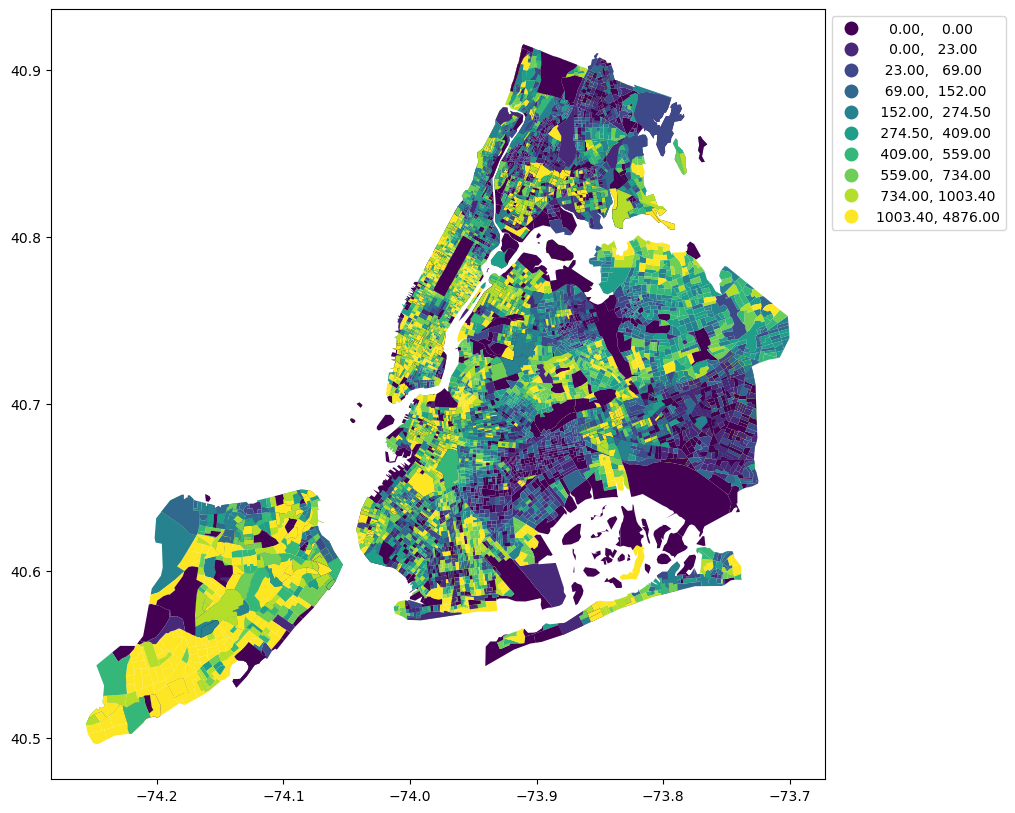

In [12]:
acs5_blockgroup_NY.plot(column = 'White, not hispanic', k=10, scheme='Quantiles',
                        markersize=0.01,figsize=(10,10),legend = True,
                        missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
                            ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

# Contingency Table & Shannon Diversity Index Calculation

In [13]:
def get_diversity_index(df, race_cols):
    
    geo_col_name = [col for col in df.columns.to_list() if col.find('GEOID') == 0][0]
    cont_tbl = df[[geo_col_name]+race_cols]
    cont_tbl.set_index(geo_col_name, inplace = True)
    
    cont_tbl['Total in Block Group'] = cont_tbl.sum(axis = 'columns')
    #drop any rows with zero total population in block group
    cont_tbl = cont_tbl[cont_tbl['Total in Block Group'] > 25]
    #compute city averages
    tot_race = cont_tbl.sum(axis = 'index')
    perc_race = tot_race / tot_race.sum()
    H_x_avg = -((perc_race*np.log(perc_race)).sum())
    
    
    cols = cont_tbl.columns.to_list()
    H_x = []
    evenness = []

    for index, row in cont_tbl.iterrows():
        perc_race = np.array(row[cols[:-1]])/row[cols[-1]]
        H = -(np.nansum(perc_race*np.log(perc_race)))
        even = H/np.log(len(cols[:-1]))
        H_x.append(H)
        evenness.append(even)

    cont_tbl['H_x'] = H_x
    cont_tbl['Evenness'] = evenness
    
    return H_x_avg, cont_tbl[['Total in Block Group','H_x','Evenness']]


In [14]:
#get NYC DI metrics
NYC_Hx, NYC_DI = get_diversity_index(acs5_blockgroup_NY,column_vals[1:])
#create metrics normalized on block group population as a fraction of total population
NYC_DI['H_x_norm'] = NYC_DI['H_x'] * NYC_DI['Total in Block Group'] / NYC_DI['Total in Block Group'].sum() *10000
NYC_DI.head()

,Total in Block Group,H_x,Evenness,H_x_norm
GEOID,,,,
360810934012,1078,0.637942,0.306785,0.452778
360050516012,1219,0.975951,0.469333,0.783279
360050516012,802,0.417702,0.200872,0.220560
360610150011,1238,0.593875,0.285594,0.484062
360470333001,769,1.079224,0.518997,0.546415


In [15]:
#NYC average DI
NYC_Hx

1.4293182007412888

In [16]:
BOS_Hx, BOS_DI = get_diversity_index(acs5_blockgroup_BOS,column_vals[1:])
BOS_DI['H_x_norm'] = BOS_DI['H_x'] * BOS_DI['Total in Block Group'] / BOS_DI['Total in Block Group'].sum() *1000
BOS_DI.head()

,Total in Block Group,H_x,Evenness,H_x_norm
GEOID20,,,,
250250406001,1479,0.908151,0.436728,1.949760
250250511011,2391,1.011732,0.486540,3.511562
250250511014,1019,0.816840,0.392817,1.208277
250250102043,771,1.060207,0.509852,1.186588
250250102042,1612,0.969853,0.466401,2.269479


In [17]:
BOS_Hx

1.3913632070132782

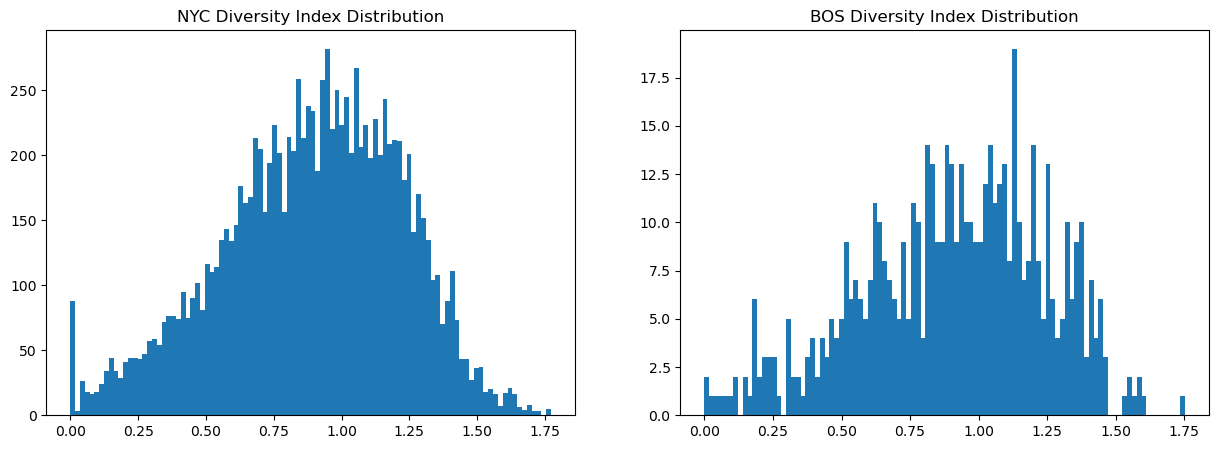

In [18]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].hist(NYC_DI['H_x'], bins = 100)
ax[0].set_title('NYC Diversity Index Distribution')
ax[1].hist(BOS_DI['H_x'], bins = 100)
ax[1].set_title('BOS Diversity Index Distribution')
plt.show()

# Comparative Statistical Analysis

In [19]:
#introduce a custom function performing distribution analysis
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return pars

#check if the distribution is normal using one-sample KS test and sample mean-std
def is_normal(x):
        return stats.kstest(x,'norm',args=(x.mean(),x.std()))

Mean = 0.89
Standard deviation = 0.33
1 percentile = 0.05
5 percentile = 0.29
25 percentile = 0.67
50 percentile = 0.92
75 percentile = 1.14
95 percentile = 1.39
99 percentile = 1.55


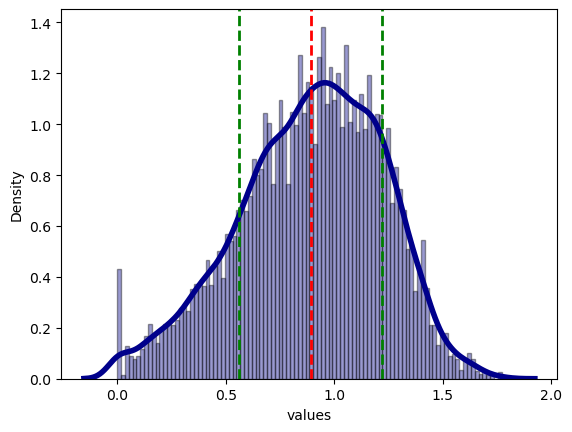

In [20]:
distribution_analysis(NYC_DI['H_x'], bins = 100)

Mean = 0.91
Standard deviation = 0.34
1 percentile = 0.09
5 percentile = 0.26
25 percentile = 0.67
50 percentile = 0.94
75 percentile = 1.14
95 percentile = 1.40
99 percentile = 1.54


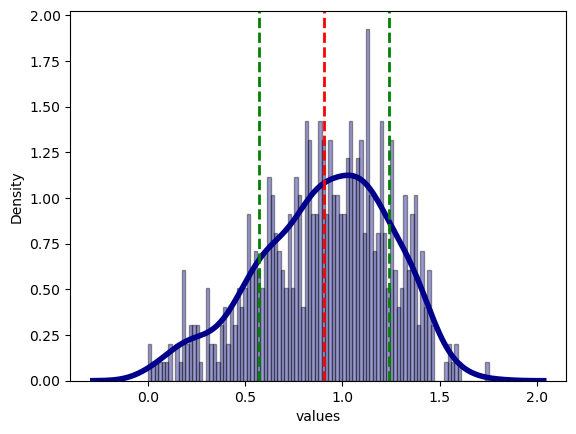

In [21]:
distribution_analysis(BOS_DI['H_x'], bins = 100)

In [22]:
stats.ttest_ind(BOS_DI['H_x'],NYC_DI['H_x'])

Ttest_indResult(statistic=1.0461518230038878, pvalue=0.2955118930716629)

In [23]:
# k-s test
stats.ks_2samp(BOS_DI['H_x'],NYC_DI['H_x'])

KstestResult(statistic=0.03634679033999666, pvalue=0.4662785601634063)

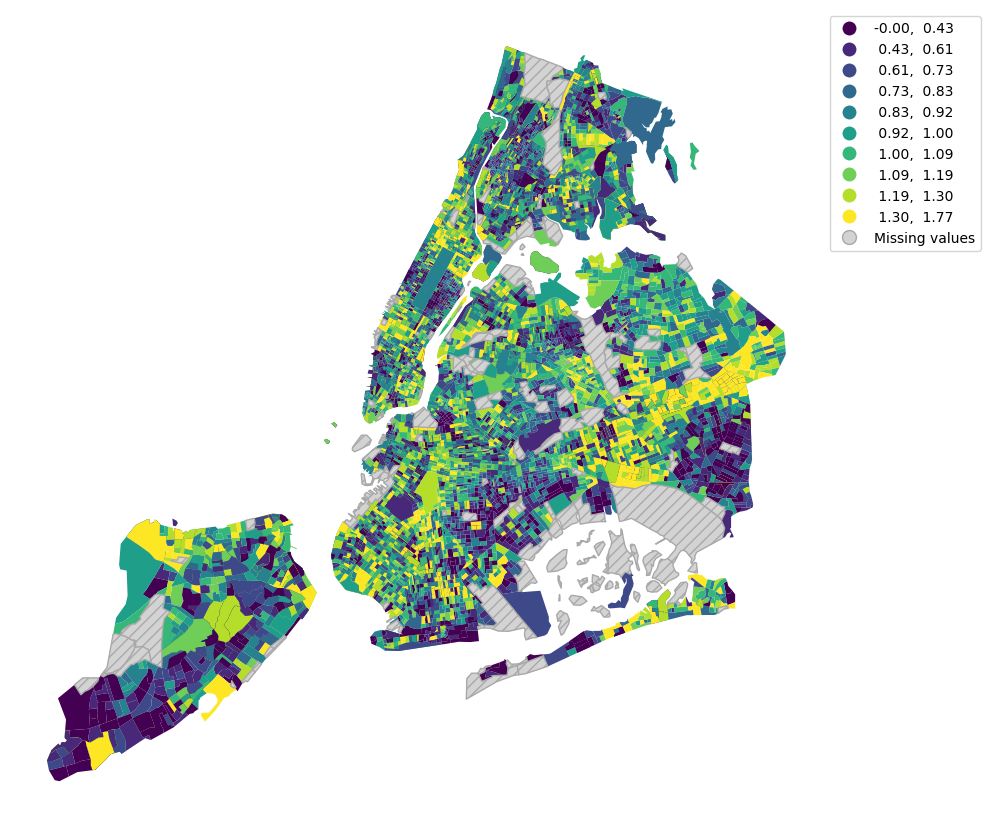

In [24]:
blockgroupNY_DI = blockgroup20_NY.merge(NYC_DI, how = 'left', on = 'GEOID')

fig, ax = plt.subplots(figsize = (10,10))
blockgroupNY_DI.plot(column = 'H_x',ax=ax, k=10, scheme='Quantiles',
                        markersize=0.01,figsize=(10,10),legend = True, 
                        missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "darkgrey",
                                        "hatch": "///",
                                        "label": "Missing values",}
                            ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
#ax.set_title(f'Diversity Index: NYC {yr}', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
fig.savefig(f'../Outputs/2020NYCDiversityIndex.png',bbox_inches = 'tight')

The average DI of census block groups in NYC and BOS are not statistically different. What happens if we look at individual boroughs of NYC vs. the entire city of Boston?

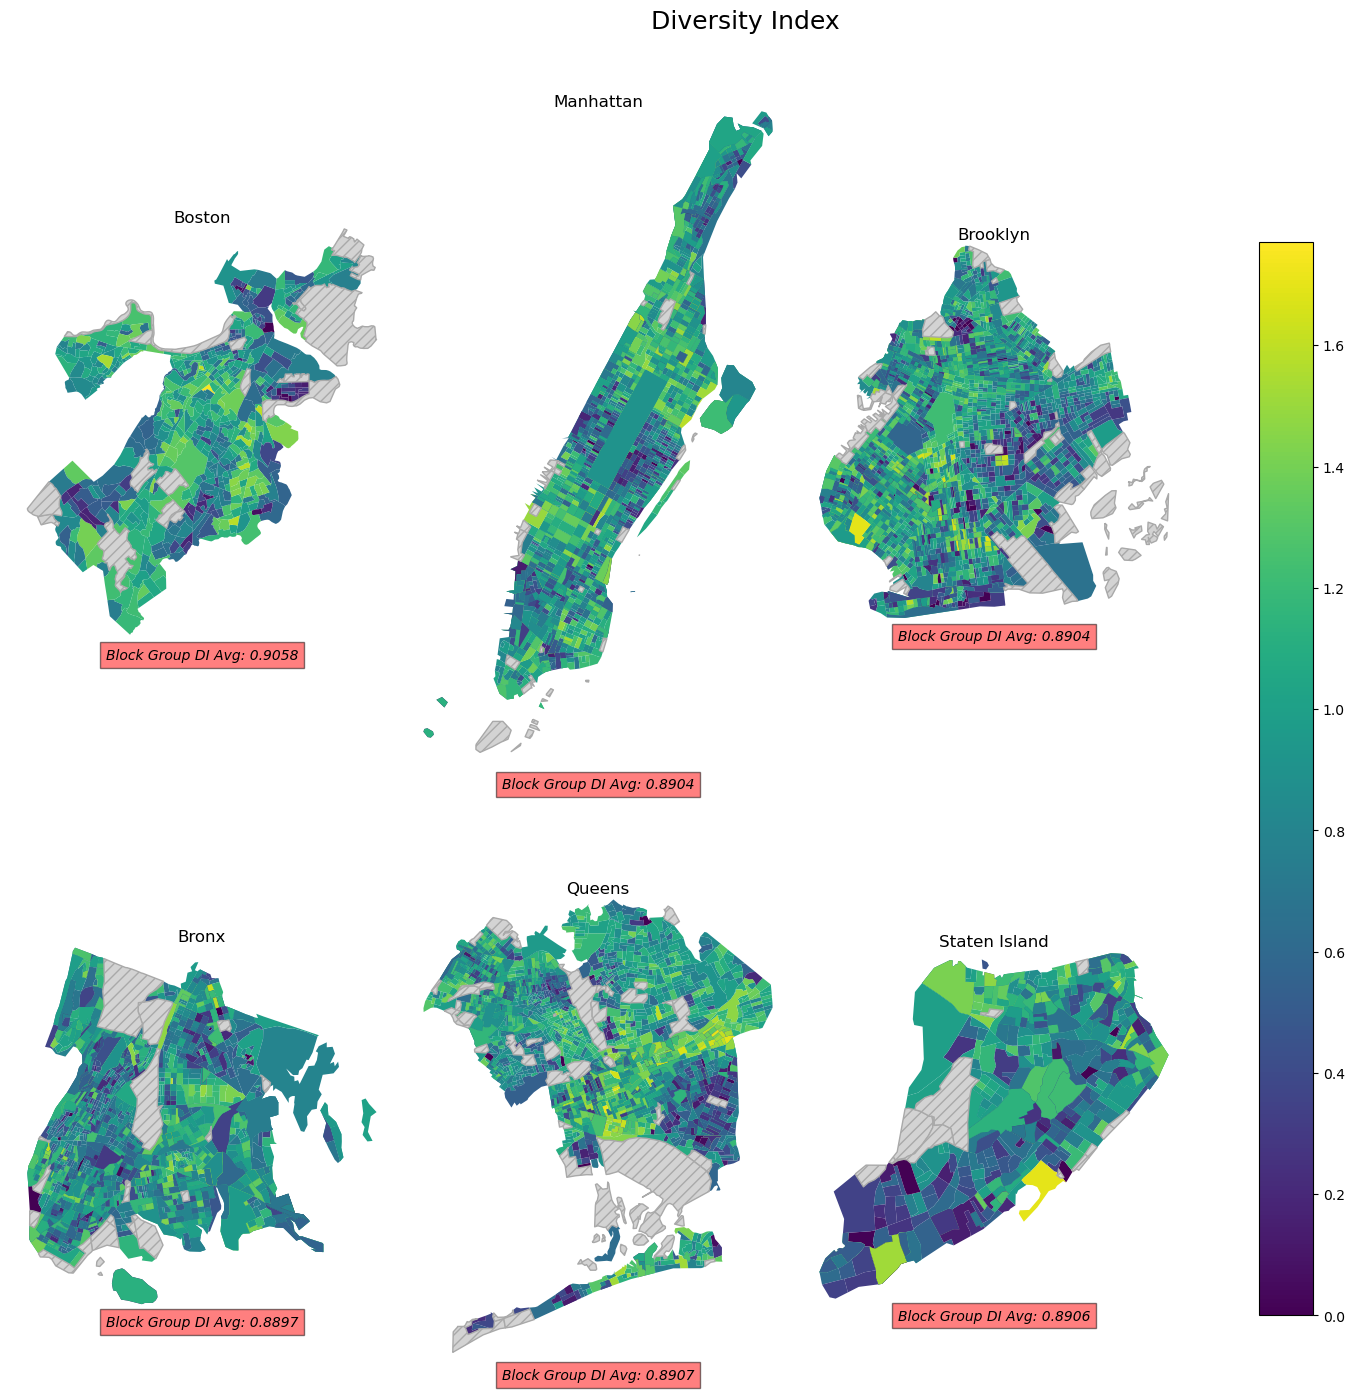

In [56]:
#create countyid to boro dict
country_boro = {'061': 'Manhattan','047':'Brooklyn','005':'Bronx','081':'Queens','085':'Staten Island'}
df = pd.DataFrame(columns = country_boro.values(), index = ['Count', 'Boro DI Avg', 'BG DI Avg', 'P-value'])

blockgroup_DI = blockgroup20_BOS.merge(BOS_DI, how = 'left', on = 'GEOID20')

i = 1

fig, ax = plt.subplots(2,3, figsize = (15,15))
norm = plt.Normalize(vmin=0, vmax=1.77)
plt.subplots_adjust(hspace = 0.5)
fig.suptitle("Diversity Index", fontsize=18, y=1)
blockgroup_DI.plot(column = 'H_x',ax=ax.flatten()[0], norm = norm, # k=10, scheme='Quantiles',
                    #markersize=0.01,legend = True, 
                    missing_kwds={"color": "lightgrey", ## what to do with missing values
                                "edgecolor": "darkgrey",
                                "hatch": "///",
                                "label": "Missing values",},
                    legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax.flatten()[0].set_title('Boston', y = 0.95)
ax.flatten()[0].text(0.5, 0, 'Block Group DI Avg: '+str(round(BOS_DI['H_x'].mean(),4)),\
                     horizontalalignment='center', verticalalignment='center',\
                     transform=ax.flatten()[0].transAxes, fontsize=10,\
                        style='oblique', bbox={'facecolor': 'red', 'alpha': 0.5})
fig.patch.set_visible(False)
ax.flatten()[0].axis('off')
plt.tight_layout()

for county in country_boro.keys():
    boro_nm = country_boro[county]
    #get acs data for boro/county id
    nyc_ethnicity = nyc_ethnicity.append(get_acs5_data(2020,'36',county,census_columns,col_dict))   
    acs5_blockgroup_NY = blockgroup20_NY.merge(nyc_ethnicity, how = 'left', left_on = ['TRACTCE','NAMELSAD'], right_on = ['Tract','Block Group'])
    
    #get diversity index for boro/county
    avg_Hx, DI_df = get_diversity_index(acs5_blockgroup_NY,column_vals[1:])
    DI_df['H_x_norm'] = DI_df['H_x'] * DI_df['Total in Block Group'] / DI_df['Total in Block Group'].sum() *10000
    
    df[boro_nm]['Count'] = len(DI_df)
    df[boro_nm]['Boro DI Avg'] = avg_Hx
    df[boro_nm]['BG DI Avg'] = DI_df['H_x'].mean()
    #ttest
    df[boro_nm]['P-value'] = stats.ttest_ind(BOS_DI['H_x'],DI_df['H_x'])[1]
    #plot
    BG_Boro_DI = blockgroup20_NY[blockgroup20_NY['COUNTYFP'] == county].merge(NYC_DI, how = 'left', on = 'GEOID')
    
    im = BG_Boro_DI.plot(column = 'H_x',ax=ax.flatten()[i], norm = norm,# k=10, scheme='Quantiles',
                        #markersize = 0.01,legend = True, 
                        missing_kwds={"color": "lightgrey", ## what to do with missing values
                                    "edgecolor": "darkgrey",
                                    "hatch": "///",
                                    "label": "Missing values",},
                        legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
    ax.flatten()[i].set_title(boro_nm, y = 0.95)
    ax.flatten()[i].text(0.5, 0, 'Block Group DI Avg: '+str(round(DI_df['H_x'].mean(),4)),\
                     horizontalalignment='center', verticalalignment='center',\
                     transform=ax.flatten()[i].transAxes, fontsize=10,\
                        style='oblique', bbox={'facecolor': 'red', 'alpha': 0.5})
    fig.patch.set_visible(False)
    ax.flatten()[i].axis('off')
    plt.tight_layout()
    
    i = i + 1

plt.colorbar(cm.ScalarMappable(norm=norm),ax=ax.ravel().tolist(), shrink = 0.75)
plt.show()
fig.savefig(f'../Outputs/2020ComparitiveAnalysis_DiversityIndex.png',bbox_inches = 'tight')

In [54]:
df['Boston'] = [len(BOS_DI), BOS_Hx, BOS_DI['H_x'].mean(), np.nan]
df

,Manhattan,Brooklyn,Bronx,Queens,Staten Island,Boston
Count,269238,272788,275028,277849,278469,563.000000
Boro DI Avg,1.428637,1.428695,1.428411,1.429137,1.428991,1.391363
BG DI Avg,0.89036,0.890318,0.889586,0.890644,0.890608,0.905805
P-value,0.268907,0.267573,0.245228,0.277719,0.276697,NaN
